<a href="https://colab.research.google.com/github/deepnoid/education/blob/master/1.%20Python%20Basic/Music_highlight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install librosa
!pip install pygame

     |████████████████████████████████| 11.4MB 4.8MB/s 


# 라이브러리 불러오기

In [4]:
from librosa import load, stft, feature, get_duration, display as dp
from sklearn.metrics.pairwise import cosine_similarity
from pygame import mixer, init, display, time, quit
import ctypes
from random import choice
import matplotlib.pyplot as plt
import numpy as np
import os

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# 플레이 정보

In [0]:
play_duration = 15                # 노래 재생 시간
file_loc = './Music'              # 노래 폴더 위치
show_chroma = True                # 크로마그램 출력

# 옵션값 모음

In [0]:
FILTER_SIZE = 9
PLUS_FILTER = 1
MINUS_FILTER = -1/9

# 필터 정보 확인하기

[[ 1.         -0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111
  -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111  1.         -0.11111111 -0.11111111 -0.11111111 -0.11111111
  -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111 -0.11111111  1.         -0.11111111 -0.11111111 -0.11111111
  -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111  1.         -0.11111111 -0.11111111
  -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111 -0.11111111  1.         -0.11111111
  -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111  1.
  -0.11111111 -0.11111111 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111
   1.         -0.11111111 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111
  -0.11111111  1.         -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111 -0.11111111
  -0.11111111 -0.11111111  1. 

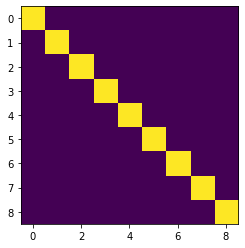

In [11]:
sample_filter = np.eye(FILTER_SIZE)
sample_filter[sample_filter == 1] = PLUS_FILTER
sample_filter[sample_filter == 0] = MINUS_FILTER

print(sample_filter)
plt.imshow(sample_filter)
plt.show()

---------------------------------------------------Music List---------------------------------------------------
전혀                        raindrop                  Bohemian Rhapsody         canon                     friday                   
blueming                 

원하는 노래 제목을 입력하세요.(랜덤 원할 경우 random 입력) raindrop


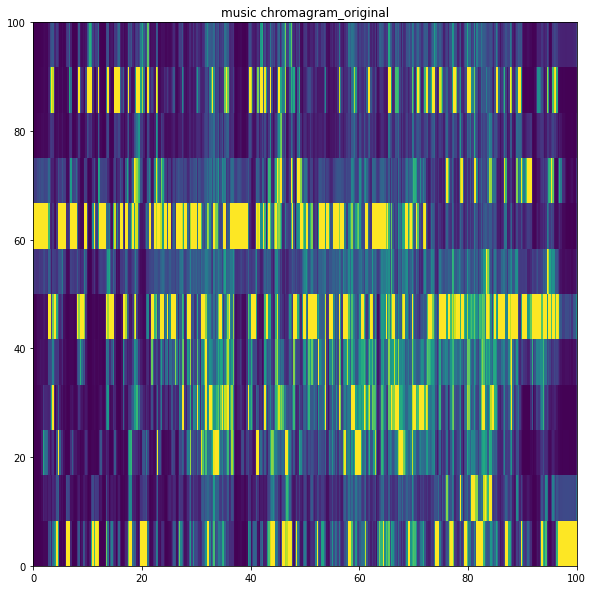

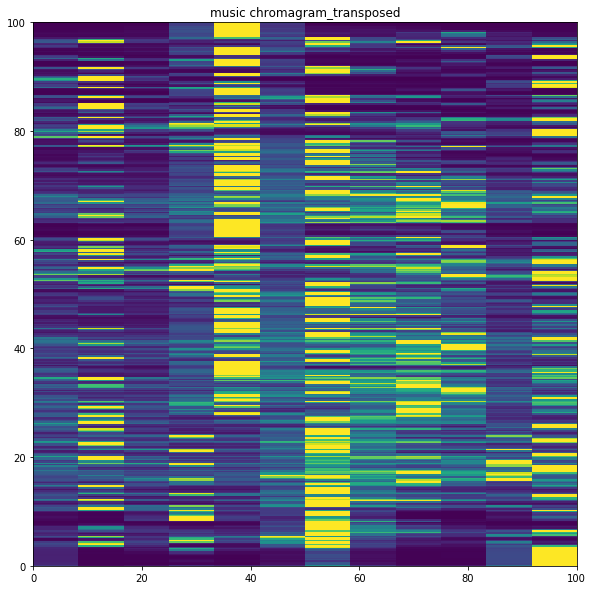


Loading Finished!


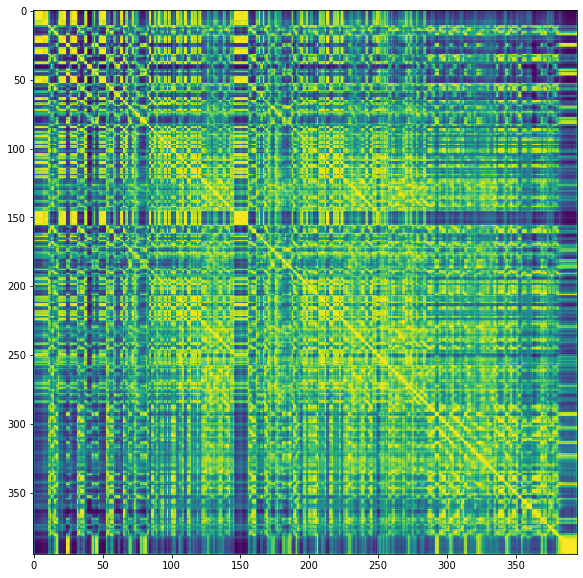

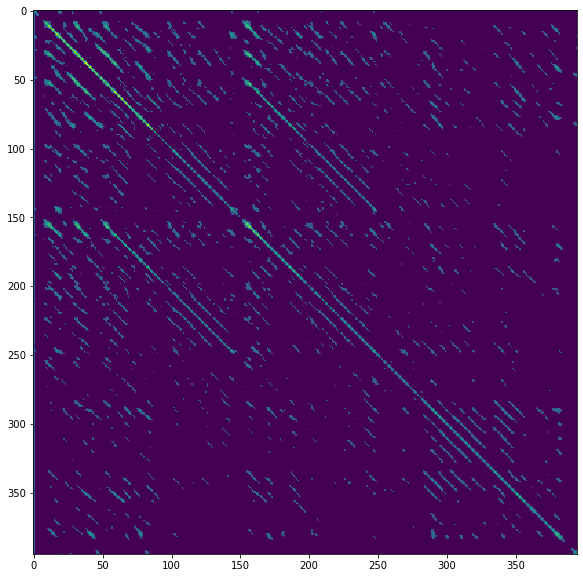

Count down 3


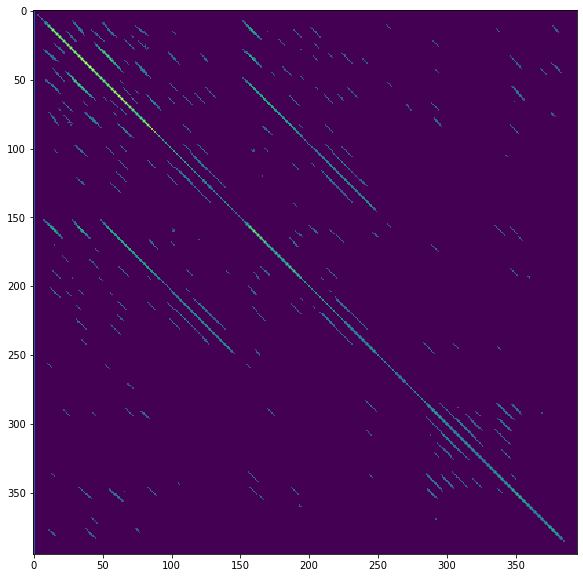

Count down 2


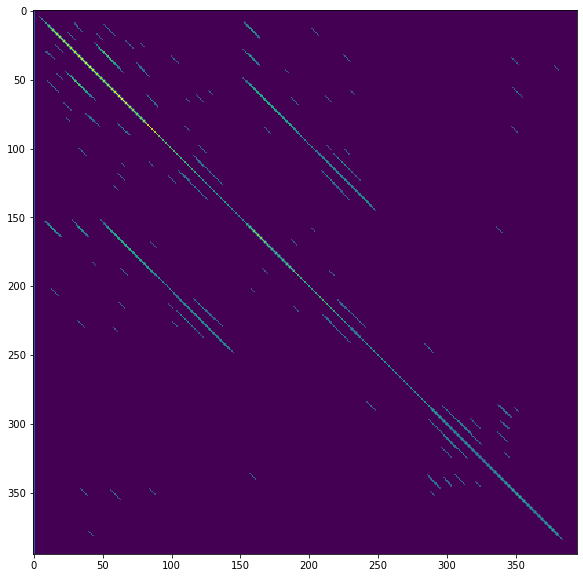

Count down 1


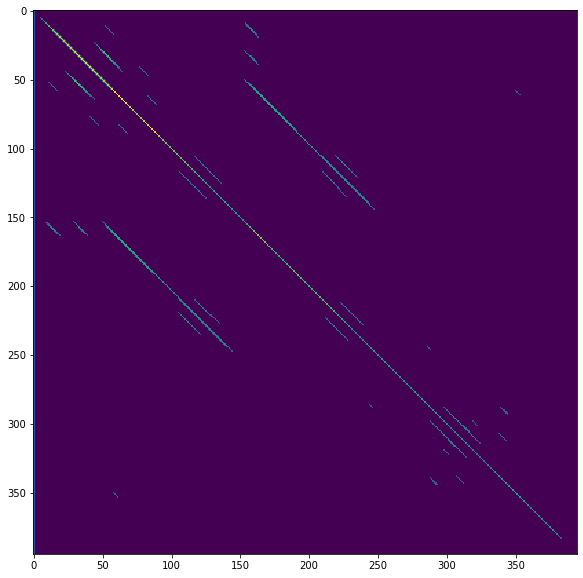


Music Name : RAINDROP
Highlight : 0m 59s, Repeated 3 times


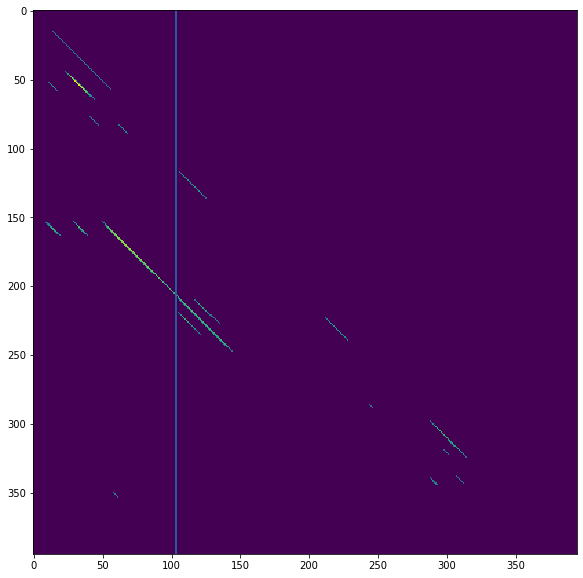

In [16]:
################## 노래 클래스 ##################
class Song(object):
    def __init__(self,show=show_chroma):
        self.music_dict = {}  # 노래 이름을 key로, 파일경로를 value로 하는 딕셔너리
        self.music = ''       # 재생할 노래 이름
        self.time = 0         # 노래 총 길이
        self.show = show      # 크로마그램 화면에 출력할지 말지 여부
        self.best_repeated_part = []      # 최종 하이라이트 시간 정보를 담는 변수
        self.chroma_len = 0
        self.highlight = 0
    ##### 노래 로딩 메소드 #####

    # (노래 로딩 Main) 노래 로드 메인 메소드(여기서 리턴한 노래의 코사인 유사도 정보를 Analysis() 메소드에서 분석)
    def _LoadSong(self):
        self.music_dict = self._SearchSong(file_loc)  # 노래, 파일경로 딕셔너리 생성
        self.music = self._Input()                    # 재생할 노래 이름 입력

        if self.music.upper() == 'RANDOM':           # 랜덤 입력시 노래 리스트 중 하나 랜덤으로 뽑기
            self.music = choice(list(self.music_dict.keys()))

        y, sr = load(self.music_dict[self.music], sr=882) # librosa 모듈의 노래 불러오기(샘플링은 0.5초 당 하나씩)
        s = np.abs(stft(y)**2)                            # 노래의 파워 데이터(주파수의 진폭)
        self.time = get_duration(y=y, sr=sr)              # 노래의 총 길이(샘플링 데이터 갯수)
        chroma = feature.chroma_stft(S=s, sr=sr)          # 크로마그램으로 변환
        #self._Chromagram(chroma, show=self.show, title='music chromagram_line41')  # 크로마그램 그래프를 출력
        plt.figure(figsize=(10, 10))
        plt.imshow(chroma, extent=(0, 100, 0, 100))
        plt.title('music chromagram_original')
        plt.show()
        
        chromaT = np.transpose(chroma,axes=(1,0))         # time-time 코사인 유사도 구하기 위해 전치행렬로 변환
#         self._Chromagram(chromaT, show=self.show, title='music transpose_line43')  # 전치화된 크로마그램 그래프를 출력
        plt.figure(figsize=(10, 10))
        plt.imshow(chromaT, extent=(0, 100, 0, 100))
        plt.title('music chromagram_transposed')
        plt.show()
        
        print('\nLoading Finished!')
        return cosine_similarity(chromaT)                 # 노래 각 부분의 코사인 유사도를 리턴

    # (노래 로딩 SUB) 폴더에서 mp3 파일 리스트를 뽑아서 딕셔너리에 담는 메소드
    def _SearchSong(self, dirname):
        filenames = os.listdir(dirname)                     # 지정된 폴더 내 파일이름들 불러오기
        music_dict = {}
        for filename in filenames:
            full_filename = os.path.join(dirname, filename) # full_filename = 경로+파일이름
            ext = os.path.splitext(full_filename)[-1]       # ext에 확장자 넣기
            file = os.path.splitext(filename)[0]            # file에 확장자를 제외한 파일이름만 넣기
            if ext == '.mp3':                               # 확장자가 mp3 인 파일만 music_dict 딕셔너리에 넣기
                music_dict[file] = full_filename            # 파일이름(key), 경로+파일이름(value)
        return music_dict                                   # music_dict 딕셔너리 리턴

    # (노래 로딩 SUB) 처음에 노래 리스트를 화면에 출력하고 재생할 노래 입력받는 메소드
    def _Input(self):
        print('---------------------------------------------------'
              'Music List---------------------------------------------------')
        music_dict_list = list(self.music_dict.keys())
        for idx in range(len(music_dict_list)//5 + 1):
            try:
                print(' '.join([i.ljust(25) for i in music_dict_list[5 * idx : 5 * idx +5]]))
            except IndexError:
                print(' '.join([i.ljust(25) for i in music_dict_list[5 * idx: -1]]))

        return input('\n원하는 노래 제목을 입력하세요.(랜덤 원할 경우 random 입력) ')

    ##### 노래 분석 메소드 #####

    # (노래 분석 MAIN) 하이라이트를 뽑아서 리턴하는 메소드(여기서 리턴한 하이라이트 정보를 Play클래스의 PlaySong()메소드에서 재생)
    def Analysis(self):
        chroma = self._Denoising()                 # 코사인유사도 정보를 Denoising()메소드를 이용해 노이즈 제거
        self.highlight = self.best_repeated_part[0] - 1.5
        self._Chromagram(chroma, show=self.show, title='final_line77')   # self.show = True 일 경우 노래 시작 전 크로마그램 그래프를 출력
        return self.best_repeated_part[0] - 1.5               # 하이라이트 시간(self.result[0])-1.5초를 리턴(하이라이트 직전부터 재생)

    # (노래 분석 SUB) 코사인 유사도의 노이즈를 제거하는 메소드(Filtering()메소드와 Tensor()메소드를 이용해 노이즈 제거)
    def _Denoising(self):
        chroma = self._LoadSong()                  # 코사인유사도를 chroma에 넣기
        self._Chromagram(chroma, show=self.show, title='after cosine similarity_line83') # 코사인 유사도 적용 후 크로마그램
        converttime = (self.time / len(chroma))   # 샘플링된 노래 시간 정보를 실제 노래 시간 정보로 변환해주기 위한 변수
        filtered_chroma = self._Filtering(chroma)  # Filtering()메소드로 chroma 의 노이즈 제거
        filterrate = 0.25                         # Filtering()메소드의 필터링 비율(하위25% 값을 제거한다는 의미)
        while filtered_chroma.all() == 0 :        # 필터링 비율이 높아 전체 값이 제거되는 경우 필터링 비율을 낮춰줌
            filtered_chroma = self._Filtering(chroma, filterrate=filterrate-0.05)
        self._FindBestParts(filtered_chroma, converttime) # 필터링된 chroma 를 FindBestParts()메소드에 넣어 하이라이트 찾기
        return filtered_chroma                    # 필터링된 chroma를 리턴

    # (노래 분석 SUB) 가장 많이 반복된 부분을 찾아서 하이라이트로 지정하는 메소드
    def _FindBestParts(self,chroma,converttime):   #
        for cn in range(len(chroma)):          # chroma에서 행과 열이 같은 부분(중복 부분)제거하여 노이즈 추가 제거
            for rn in range(cn):
                chroma[rn][cn] = 0
        chroma[chroma <= 0] = 0                # 노이즈 추가 제거 2
        repeatedcnt = self._LineFilter(chroma)  # LineFilter()메소드 사용해 시간대별 반복횟수 카운트한 리스트 생성
        best_repeated = round(converttime * max(repeatedcnt, key = lambda item: item[1])[0],1) # 최다 반복된 부분 선택
        best_repeated_cnt = max(repeatedcnt, key = lambda item: item[1])[1]
        print('\nMusic Name : {}'.format(self.music.upper()))
        best_repeated_print = best_repeated - 2
        print('Highlight : {}m {}s, Repeated {} times'.format(int(best_repeated_print//60), int(best_repeated_print%60), best_repeated_cnt))
        self.best_repeated_part.append(best_repeated)  # best_repeated_part 에 하이라이트 부분 넣기

    ##### 노래 필터링 메소드 #####

    # (필터링1 MAIN) 노이즈 제거 시 쓰는 필터링 메소드
    def _Filtering(self, chroma, cnt=3, filterrate = 0.25):
        recursive_cnt = cnt                                  # 재귀횟수
        if recursive_cnt == 3 :
            self.chroma_len = len(chroma)
#         chroma = np.pad(chroma, pad_width=int((FILTER_SIZE-1)/2), mode='constant', constant_values=0)
        pad_width = (FILTER_SIZE-1)/2
        
        chroma = np.pad(
            chroma, [(int(pad_width), int(np.ceil(pad_width))), (int(pad_width), int(np.ceil(pad_width)))],
            mode='constant', constant_values=0
        )
        
#         np.pad(a, [(0, 1), (0, 1)], mode='constant')
        chroma = Common.im2col_sliding_strided(chroma, (FILTER_SIZE, FILTER_SIZE))
        chroma = np.dot(chroma, self._Tensor()) / FILTER_SIZE
        chroma = chroma.reshape(self.chroma_len,-1)
        chroma[chroma <= filterrate * np.max(chroma)] = 0    # 노이즈 제거
        self._Chromagram(chroma, show=self.show, title='filtering_line116')  # 필터링한 크로마그램 그래프를 출력

        if recursive_cnt == 0:                               # 마지막 재귀 시 chroma 를 정규화시켜서 데이터 정제하고 리턴
            return Common.Normalization(chroma)

        print('Count down', recursive_cnt)
        return self._Filtering(chroma, cnt=recursive_cnt - 1) # 재귀를 3번 돌리며 필터링

    # (필터링1 SUB) 필터링 시 사용하는 Tensor 를 만드는 메소드
    def _Tensor(self):
        tensor = np.eye(FILTER_SIZE, FILTER_SIZE).reshape(-1,1)
        tensor[tensor<=0] = MINUS_FILTER
        tensor[tensor>0] = PLUS_FILTER
        return tensor

    # (필터링2) 코사인 유사도가 높은 대각선 방향의 패턴을 카운팅하는 메소드
    def _LineFilter(self,chroma, mincorrectcnt=3, line=25):
        mincnt = mincorrectcnt  # 최소 일치 횟수(대각선 패턴이 일정 횟수 이상 반복되는 경우에 리턴시키도록 제한하여 필터링 질 향상)
        shorterline = line      # 패턴 반복 확인 시 사용할 기준 대각선의 길이
        repeatedcnt = []        # 시간대별 반복횟수 저장할 리스트

        for cn in range(len(chroma)-line):
            correctcnt = 0      # 패턴 일치 횟수
            for rn in range(len(chroma)-line):
                cnt = 0
                while chroma[rn+cnt][cn+cnt] != 0 and cnt < line:
                    cnt += 1
                if cnt == line: # 패턴 일치할 경우 correctcnt 하나씩 증가
                    correctcnt += 1
            repeatedcnt.append([cn,correctcnt]) # 시간대와 시간대별 일치횟수를 리스트에 저장

        #--- 이하 리턴절은 3가지의 시나리오로 나뉘어짐 ---#

        # 3.기준 대각선의 길이가 5가 될때가지 최소 일치 횟수를 충족시키지 못한경우 재귀하여 최소 일치 횟수를 줄여서 패턴 확인
        if line <= 5 :
            return self._LineFilter(chroma, mincorrectcnt=mincnt-1, line=25)

        # 1.최소 일치 횟수 이상 패턴이 반복될 경우 정상적으로 리턴
        if max(repeatedcnt, key=lambda k:k[1])[1] >= mincnt:
            return repeatedcnt
        # 2.최소 일치 횟수 이상 패턴이 반복되지 않는 경우 기준 대각선의 길이를 5만큼 줄여서 재귀하여 패턴 확인
        return self._LineFilter(chroma, mincorrectcnt=mincnt, line=shorterline-5)

    ##### 크로마그램 출력 메소드 #####

    def _Chromagram(self, chroma, show=False, title=None):
        if show == True:
            plt.figure(figsize=(10, 10))
            plt.imshow(chroma)
            plt.axvline(x=  self.highlight * len(chroma) / self.time )
            plt.show()

################## 재생 클래스 ##################
class Play(object):
    @staticmethod
    def PlaySong():
        song = Song()
        highlight = song.Analysis()

################## 기타 함수 클래스 ##################
class Common:
    # 행렬곱하기 좋게 행렬을 변환시켜주는 메소드
    @staticmethod
    def im2col_sliding_strided(A, padsize, stepsize=1):
        m, n = A.shape
        s0, s1 = A.strides
        BSZ = [m + 1 - padsize[0], n + 1 - padsize[1]]
        nrows = m - BSZ[0] + 1
        ncols = n - BSZ[1] + 1
        shp = BSZ[0], BSZ[1], nrows, ncols
        strd = s0, s1, s0, s1

        out_view = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
        return out_view.reshape(BSZ[0] * BSZ[1], -1)[:, ::stepsize]

    # 정규화 메소드
    @staticmethod
    def Normalization(chroma):
        for idx in range(len(chroma)):
            chroma[idx][idx] = 0
        return (chroma-np.mean(chroma))/np.max(chroma)
    
Play.PlaySong()    